In [1]:
import networkx as nx

In [4]:
G = nx.read_gml('processed/years/2018-grouped/orig/month-1.gml')

In [6]:
G.number_of_nodes(), G.number_of_edges()

(255, 13784)

In [7]:
import glob

null_models = glob.glob('processed/years/2018-grouped/null/month-1-*.gml')

In [19]:
from bct.algorithms.motifs import motif3struct_wei, make_motif34lib, find_motif34
from bct.utils.other import weight_conversion

In [9]:
make_motif34lib()

motif34lib already exists


In [16]:
A = nx.to_numpy_array(G, weight='trip_count_weights')

In [20]:
An = weight_conversion(A, 'normalize') # An = A / A.max()

In [21]:
I, Q, F = motif3struct_wei(An)

In [46]:
I_orig = I.sum(axis=1)

In [51]:
import numpy as np
import multiprocessing as mp

In [26]:
def do_motifs(filename):

    try:
        G = nx.read_gml(filename)
        A = nx.to_numpy_array(G, weight='trip_count_weights')
        An = weight_conversion(A, 'normalize')
        I, Q, F = motif3struct_wei(An)
        return I.sum(axis=1)
    except Exception as e:
        return None


with mp.Pool() as pool:
    results = pool.map(do_motifs, null_models, chunksize=1)

In [38]:
I_null = np.vstack(results).T

In [47]:
I_null_mean, I_null_std = I_null.mean(axis=1), I_null.std(axis=1)

In [50]:
(I_orig - I_null_mean) / I_null_std

array([-20.55728866, -25.87738656, -15.12439812,  -6.4164786 ,
       -24.814956  ,   1.65038453, -19.59277539, -13.12284882,
        11.02458379, -14.03334293,  -9.52607974,   6.41774883,
        18.06921307])

In [55]:
from tqdm.notebook import tqdm

month_z_scores = []

for month in tqdm(range(1, 13)):
    
    G = nx.read_gml(f'processed/years/2018-grouped/orig/month-{month}.gml')

    null_models = glob.glob(f'processed/years/2018-grouped/null/month-{month}-*.gml')

    A = nx.to_numpy_array(G, weight='trip_count_weights')

    An = weight_conversion(A, 'normalize') # An = A / A.max()

    I, Q, F = motif3struct_wei(An)

    I_orig = I.sum(axis=1)

    with mp.Pool() as pool:
        results = pool.map(do_motifs, null_models, chunksize=1)

    I_null = np.vstack(results).T

    I_null_mean, I_null_std = I_null.mean(axis=1), I_null.std(axis=1)

    month_z = (I_orig - I_null_mean) / I_null_std

    month_z_scores.append(month_z)

  0%|          | 0/12 [00:00<?, ?it/s]

In [61]:
all_z_scores = np.vstack(month_z_scores).T

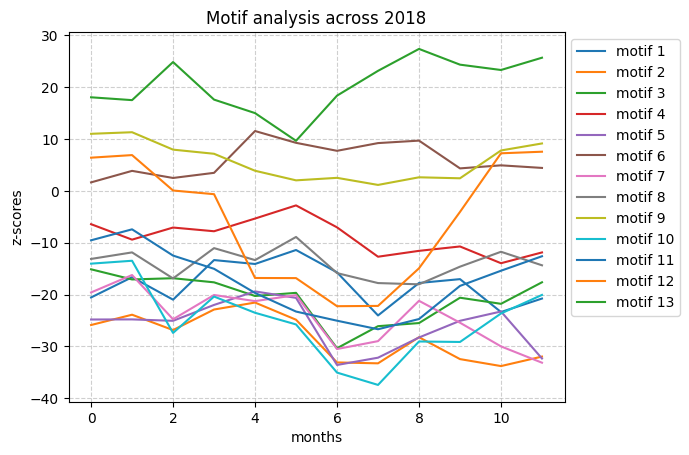

In [73]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap

cmap = matplotlib.colormaps['viridis']
colors = [cmap(i) for i in range(10)]

fig, ax = plt.subplots()

for motif, z_scores in enumerate(all_z_scores):

    ax.plot(z_scores, label=f"motif {motif + 1}")

plt.xlabel("months")
plt.ylabel("z-scores")
plt.title("Motif analysis across 2018")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

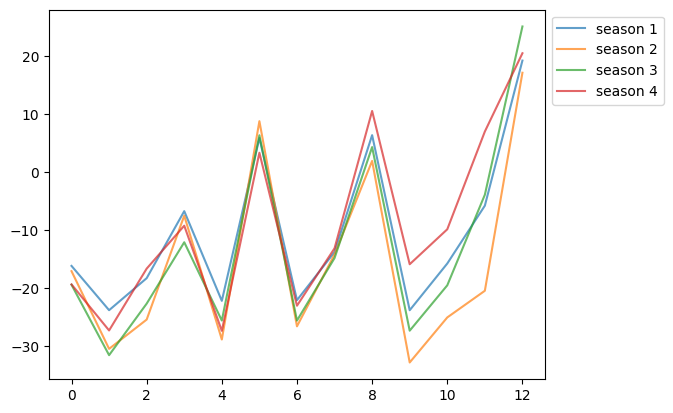

In [77]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

groups = [[2, 3, 4], [5, 6, 7], [8, 9, 10], [11, 0, 1]]

for season_n, season in enumerate(groups):

    season_z_scores = all_z_scores.T[season, :].mean(axis=0)

    ax.plot(season_z_scores, label=f"season {season_n + 1}", alpha=0.7)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [65]:
np.save('compute_motif.npy', all_z_scores)